# ResNet

## Configuration

Imports

In [40]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.utils import convert_tensor
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [41]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 20
BATCH_SIZE = 32
NUM_BA_COPIES = 4
EPOCHS = 200

In [42]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda:0


## Data

In [43]:
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomErasing(p=0.1)
])

In [44]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [45]:
class CollateFN:
    def __init__(self, transform, num_copies=1):
        self.transform = transform
        self.num_copies = num_copies
    
    def __call__(self, batch):
        images, labels = zip(*batch)
        
        transformed_images = [self.transform(img) for img in images for _ in range(self.num_copies)]
        new_labels = [lbl for lbl in labels for _ in range(self.num_copies)]
        X = torch.stack(transformed_images, dim=0)
        Y = torch.tensor(new_labels)
        return X, Y

In [46]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           collate_fn=CollateFN(train_transform, NUM_BA_COPIES),
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [47]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

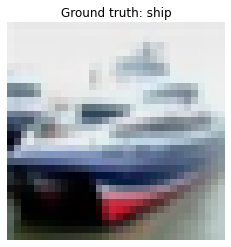

In [48]:
dataset_show_image(test_dset, 1)

## Model

In [49]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.SiLU(inplace=True))
        super().__init__(*layers)

In [50]:
class BasicResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels, p_drop=0.):
        super().__init__(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels, act=False),
            nn.Dropout2d(p_drop)
        )

In [51]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, p_drop=0.):
        super().__init__()
        self.shortcut = self.get_shortcut(in_channels, out_channels)
        self.residual = BasicResidual(in_channels, out_channels, p_drop)
        self.act = nn.SiLU(inplace=True)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = self.shortcut(x) + self.gamma * self.residual(x)
        return self.act(out)
    
    def get_shortcut(self, in_channels, out_channels):
        if in_channels != out_channels:
            shortcut = ConvBlock(in_channels, out_channels, 1, act=False)
        else:
            shortcut = nn.Identity()
        return shortcut

In [52]:
class ResidualStack(nn.Sequential):
    def __init__(self, in_channels, repetitions, strides, p_drop=0.):
        layers = []
        out_channels = in_channels
        for rep, stride in zip(repetitions, strides):
            if stride > 1: layers.append(nn.MaxPool2d(stride))
            for _ in range(rep):
                layers.append(ResidualBlock(in_channels, out_channels, p_drop))
                in_channels = out_channels
            out_channels *= 2
        super().__init__(*layers)

In [53]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, channel_list, stride):
        layers = []
        for out_channels in channel_list:
            layers.append(ConvBlock(in_channels, out_channels, 3, stride=stride))
            in_channels = out_channels
            stride = 1
        super().__init__(*layers)

In [54]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [135]:
class ResNet(nn.Sequential):
    def __init__(self, classes, repetitions, strides=None, in_channels=3, res_p_drop=0., head_p_drop=0.):
        if strides is None: strides = [2] * (len(repetitions) + 1)
        super().__init__(
            Stem(in_channels, [24, 24, 48], strides[0]),
            ResidualStack(48, repetitions, strides[1:], res_p_drop),
            Head(48 * 2**(len(repetitions) - 1), classes, head_p_drop)
        )

In [136]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [137]:
model = ResNet(NUM_CLASSES, [2, 2, 2, 2], strides=[1, 1, 2, 2, 2], res_p_drop=0., head_p_drop=0.3)

In [138]:
model.apply(init_linear);

In [139]:
model.to(DEVICE);

In [140]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,303,450


## Loss

In [141]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [142]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε=0.1, reduction='mean'):
        super().__init__()
        self.ε = ε
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size(-1)
        log_preds = F.log_softmax(output, dim=-1)
        loss1 = reduce_loss(-log_preds.sum(dim=-1) / c, self.reduction)
        loss2 = F.nll_loss(log_preds, target, reduction=self.reduction)
        loss = (1. - self.ε) * loss2 + self.ε * loss1
        return loss

## CutMix

In [143]:
class CutMix(nn.Module):
    def __init__(self, loss, α=1.0):
        super().__init__()
        self.loss = loss
        self.α = α
        self.rng = np.random.default_rng()
    
    def prepare_batch(self, batch, device, non_blocking):
        x, y = batch
        x = convert_tensor(x, device=device, non_blocking=non_blocking)
        y = convert_tensor(y, device=device, non_blocking=non_blocking)
        
        batch_size = x.size(0)
        self.index = torch.randperm(batch_size).to(device)
        
        self.λ = self.rng.beta(self.α, self.α)
        y1, x1, y2, x2 = self.cut_bounding_box(x.shape[-2:], self.λ)
        x[:, :, y1:y2, x1:x2] = x[self.index, :, y1:y2, x1:x2]
                
        # adjust lambda to exactly match pixel ratio
        area = x.size(2) * x.size(3)
        self.λ = 1. - (x2 - x1) * (y2 - y1) / area
        return x, y
    
    def cut_bounding_box(self, shape, λ):
        cut_size_2 = 0.5 * np.sqrt(1. - λ)
        center_yx = self.rng.random(2)
        
        y1x1 = (np.clip(center_yx - cut_size_2, 0., 1.) * shape).astype(int)
        y2x2 = (np.clip(center_yx + cut_size_2, 0., 1.) * shape).astype(int)
        return np.concatenate((y1x1, y2x2))
        
    def forward(self, pred, target):
        orig_reduction = self.loss.reduction
        self.loss.reduction = 'none'
        batch_loss = self.λ * self.loss(pred, target) + (1. - self.λ) * self.loss(pred, target[self.index])
        self.loss.reduction = orig_reduction
        return reduce_loss(batch_loss, orig_reduction)

## Training

### History

In [145]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _begin_plot(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)

    def _end_plot(self, ylabel):
        self.ax.set_xlabel('epoch')
        self.ax.set_ylabel(ylabel)
        plt.show()

    def _plot(self, key, line_type='-', label=None):
        if label is None: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label=label)

    def plot(self, key):
        self._begin_plot()
        self._plot(key, '-')
        self._end_plot(key)

    def plot_train_val(self, key):
        self._begin_plot()
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        self._end_plot(key)

### Trainer Setup

In [146]:
loss = LabelSmoothingCrossEntropy()

In [147]:
cutmix = CutMix(loss, α=1.0)

AdamW optimizer, [arXiv:1711.05101 [cs.LG]](https://arxiv.org/abs/1711.05101)

In [148]:
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)

In [150]:
trainer = create_supervised_trainer(model, optimizer, cutmix, device=DEVICE, prepare_batch=cutmix.prepare_batch)

"1cycle" leraning rate policy, [arXiv:1803.09820 [cs.LG]](https://arxiv.org/abs/1803.09820)

In [151]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [152]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [153]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [154]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [155]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [156]:
history = History()

In [157]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history.append('train loss', train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history.append('val loss', val_loss)
    history.append('val acc', val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Training

In [158]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/200 - train: loss 1.963; val: loss 1.303 accuracy 0.653
2/200 - train: loss 1.877; val: loss 1.127 accuracy 0.732
3/200 - train: loss 1.764; val: loss 1.027 accuracy 0.786
4/200 - train: loss 1.767; val: loss 1.012 accuracy 0.796
5/200 - train: loss 1.678; val: loss 0.931 accuracy 0.831
6/200 - train: loss 1.695; val: loss 0.923 accuracy 0.836
7/200 - train: loss 1.669; val: loss 0.902 accuracy 0.850
8/200 - train: loss 1.603; val: loss 0.873 accuracy 0.863
9/200 - train: loss 1.599; val: loss 0.863 accuracy 0.857
10/200 - train: loss 1.565; val: loss 0.823 accuracy 0.871
11/200 - train: loss 1.547; val: loss 0.824 accuracy 0.881
12/200 - train: loss 1.626; val: loss 0.833 accuracy 0.884
13/200 - train: loss 1.552; val: loss 0.828 accuracy 0.892
14/200 - train: loss 1.551; val: loss 0.806 accuracy 0.889
15/200 - train: loss 1.539; val: loss 0.794 accuracy 0.892
16/200 - train: loss 1.540; val: loss 0.785 accuracy 0.892
17/200 - train: loss 1.477; val: loss 0.776 accuracy 0.899
18/200

140/200 - train: loss 1.358; val: loss 0.625 accuracy 0.953
141/200 - train: loss 1.305; val: loss 0.663 accuracy 0.939
142/200 - train: loss 1.341; val: loss 0.656 accuracy 0.940
143/200 - train: loss 1.338; val: loss 0.628 accuracy 0.952
144/200 - train: loss 1.301; val: loss 0.620 accuracy 0.954
145/200 - train: loss 1.297; val: loss 0.616 accuracy 0.954
146/200 - train: loss 1.292; val: loss 0.640 accuracy 0.945
147/200 - train: loss 1.331; val: loss 0.613 accuracy 0.956
148/200 - train: loss 1.329; val: loss 0.613 accuracy 0.955
149/200 - train: loss 1.298; val: loss 0.613 accuracy 0.956
150/200 - train: loss 1.306; val: loss 0.619 accuracy 0.954
151/200 - train: loss 1.299; val: loss 0.613 accuracy 0.957
152/200 - train: loss 1.268; val: loss 0.616 accuracy 0.954
153/200 - train: loss 1.281; val: loss 0.607 accuracy 0.957
154/200 - train: loss 1.276; val: loss 0.599 accuracy 0.961
155/200 - train: loss 1.289; val: loss 0.603 accuracy 0.961
156/200 - train: loss 1.282; val: loss 0

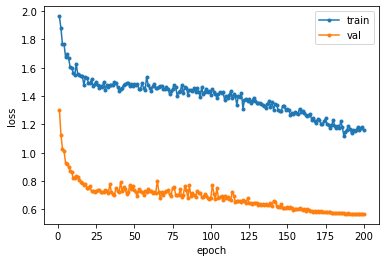

In [159]:
history.plot_train_val('loss')

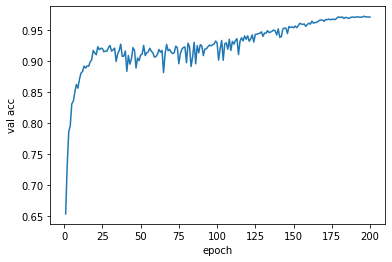

In [160]:
history.plot('val acc')

In [161]:
SAVE_PATH = './models/resnet_weights.pkl'
torch.save(model.state_dict(), SAVE_PATH)